<a href="https://colab.research.google.com/github/ekrell/shap_multiband/blob/main/EuroSAT_All_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsat
!pip install shap

In [51]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# Torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
# Torchsat
import torchsat.transforms.functional as F
import torchsat.transforms.transforms_cls as T_cls
from torchsat.transforms import transforms_cls
import torchsat.datasets as datasets
from torchsat.datasets.folder import DatasetFolder
from torchsat.datasets.utils import tifffile_loader
import torchsat.models
from torchsat.models.classification.resnet import resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, wide_resnet50_2, wide_resnet101_2
# Sci
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from PIL import Image
# General
import matplotlib.pyplot as plt
import copy
from collections import namedtuple
import os
import random
import shutil
import time
from pathlib import Path
import math
# XAi
import shap

In [52]:
# Project paths
url_data = "/content/drive/MyDrive/Data/"
url_python = "/content/drive/MyDrive/Python/"
url_models = "/content/drive/MyDrive/Models/"
path_meanSD = url_data + "/" + "mean_sd.txt"
path_model = url_models + "/" + "eurosat_landuse.pt"
projectDir = Path(url_data + "/" + "EuroSatAllBands/")
imgDir = Path(projectDir, "ImagesSmallSep")

In [53]:
def imgShow(x, ax=None):
  img = Image.fromarray(np.uint8(x[:,:,1:4][:,:,(2, 0, 1)] >> 4))
  if ax == None:
    plt.imshow(img)
  ax.imshow(img)

# Load model & data

In [54]:
# Load model
model = torch.load(path_model)
model.eval();

In [66]:
# Define transformers
train_transform = T_cls.Compose([
    T_cls.RandomHorizontalFlip(),
    T_cls.RandomVerticalFlip(),
    T_cls.ToTensor(),
    # T_cls.Normalize(mean=meanSD[0], std=meanSD[1]),
])
val_transform = T_cls.Compose([
    T_cls.ToTensor(),
    # T_cls.Normalize(mean=meanSD[0], std=meanSD[1]),
])

# Load data from folders
trainData = datasets.folder.DatasetFolder(Path(imgDir, "train"), datasets.utils.tifffile_loader, ".tif", transform=train_transform)
valData   = datasets.folder.DatasetFolder(Path(imgDir, "val"),   datasets.utils.tifffile_loader, ".tif", transform=val_transform)
valDataRaw = datasets.folder.DatasetFolder(Path(imgDir, "val"),  datasets.utils.tifffile_loader, ".tif")
testData  = datasets.folder.DatasetFolder(Path(imgDir, "test"),  datasets.utils.tifffile_loader, ".tif")

# Data information
classes = trainData.classes
n_classes = len(classes)
n_train = len(trainData)
n_val = len(valData)
n_test = len(testData)

batchSize = 64

val_loader   = DataLoader(valData,   batch_size=batchSize, shuffle=False)

# Prediction

In [56]:
class_to_idx = {
        'AnnualCrop': 0,
        'Forest': 1,
        'HerbaceousVegetation': 2,
        'Highway': 3,
        'Industrial': 4,
        'Pasture': 5,
        'PermanentCrop': 6,
        'Residential': 7,
        'River': 8,
        'SeaLake': 9,
    }
idx_to_class = {v: k for k, v in class_to_idx.items()}

ckp = url_models + "/" + "cls_epoch_22.pth"
model.load_state_dict(torch.load(ckp, map_location=torch.device('cuda')))

<All keys matched successfully>

predict class: Residential


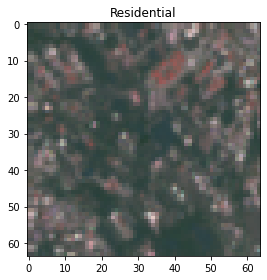

In [57]:
# Get test image
image, target = testData[200]
# Plot test image
fig, ax = plt.subplots(1);
imgShow(image, ax=ax);
ax.set_title(classes[target]);
plt.tight_layout()

# Convert to tensor
image = F.to_tensor(image)
# Normalize (with train data mean, std. dev.)
# image = F.normalize(image, meanSD[0], meanSD[1])
# Reshape for the model [bands, h, w] -> [batch size, bands, h, w]
image = torch.unsqueeze(image, 0) 
# Place on device
image.to("cpu", dtype=torch.double)

# (image, target) 
# image = image.to(device, dtype=torch.float, non_blocking=True)

model.to("cpu", dtype=torch.double)

model.eval()
with torch.no_grad():
  
  output = model(image)
  predict_class = output.argmax(dim=1,).item()

  print('predict class: {}'.format(idx_to_class.get(predict_class)))

In [58]:
def m(X):
  # Go from (batch size, height, width, channels)
  #      to (batch size, channels, height, width)
  X = np.moveaxis(X, (0, 1, 2, 3), (0, 2, 3, 1))

  # Numpy to pytorch tensor
  # image = val_transform(X)
  image = torch.from_numpy(X)  #.ToTensor()

  # Prepare input, model for evaluation
  image.to(device="cpu", dtype=torch.float)
  model.to("cpu", dtype=torch.double)
  
  # Evaluate model
  res = model(image)
  return res.detach().numpy()

In [ ]:
# Get batch of images, labels
batch = next(iter(val_loader))
X = batch[0]
y = batch[1]

# Convert from tensor (from pytorch) to generic numpy (for shap)
Xshap = X.numpy()
# Go from (batch size, channels, height, width)
#      to (batch size, height, width, channels)
Xshap = np.moveaxis(Xshap, (0, 1, 2, 3), (0, 3, 1, 2))

# Initial masker and PartitionShap
masker = shap.maskers.Image("blur(20, 20)", Xshap[0].shape)
explainer = shap.Explainer(m, masker, output_names=classes)

# Explain batch (calculate shap values)
shap_values = explainer(Xshap, max_evals=500, batch_size=batchSize, outputs=shap.Explanation.argsort.flip)

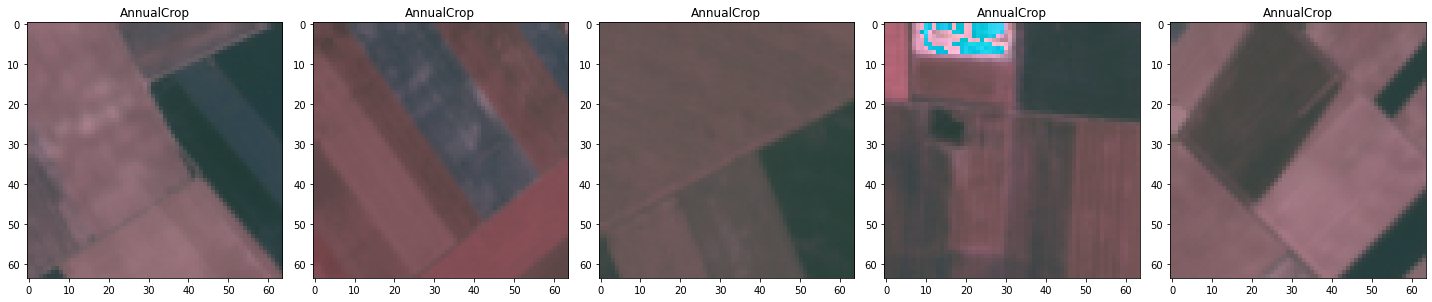

In [72]:
# Accessing images from dataset
fig, axs = plt.subplots(1, 5, figsize=(20,4));
# Train sample
image, target = valDataRaw[0]
imgShow(image, ax=axs[0]);
axs[0].set_title(classes[target])
image, target = valDataRaw[1]
imgShow(image, ax=axs[1]);
axs[1].set_title(classes[target])
image, target = valDataRaw[2]
imgShow(image, ax=axs[2]);
axs[2].set_title(classes[target])
image, target = valDataRaw[3]
imgShow(image, ax=axs[3]);
axs[3].set_title(classes[target])
image, target = valDataRaw[4]
imgShow(image, ax=axs[4]);
axs[4].set_title(classes[target])

plt.tight_layout()

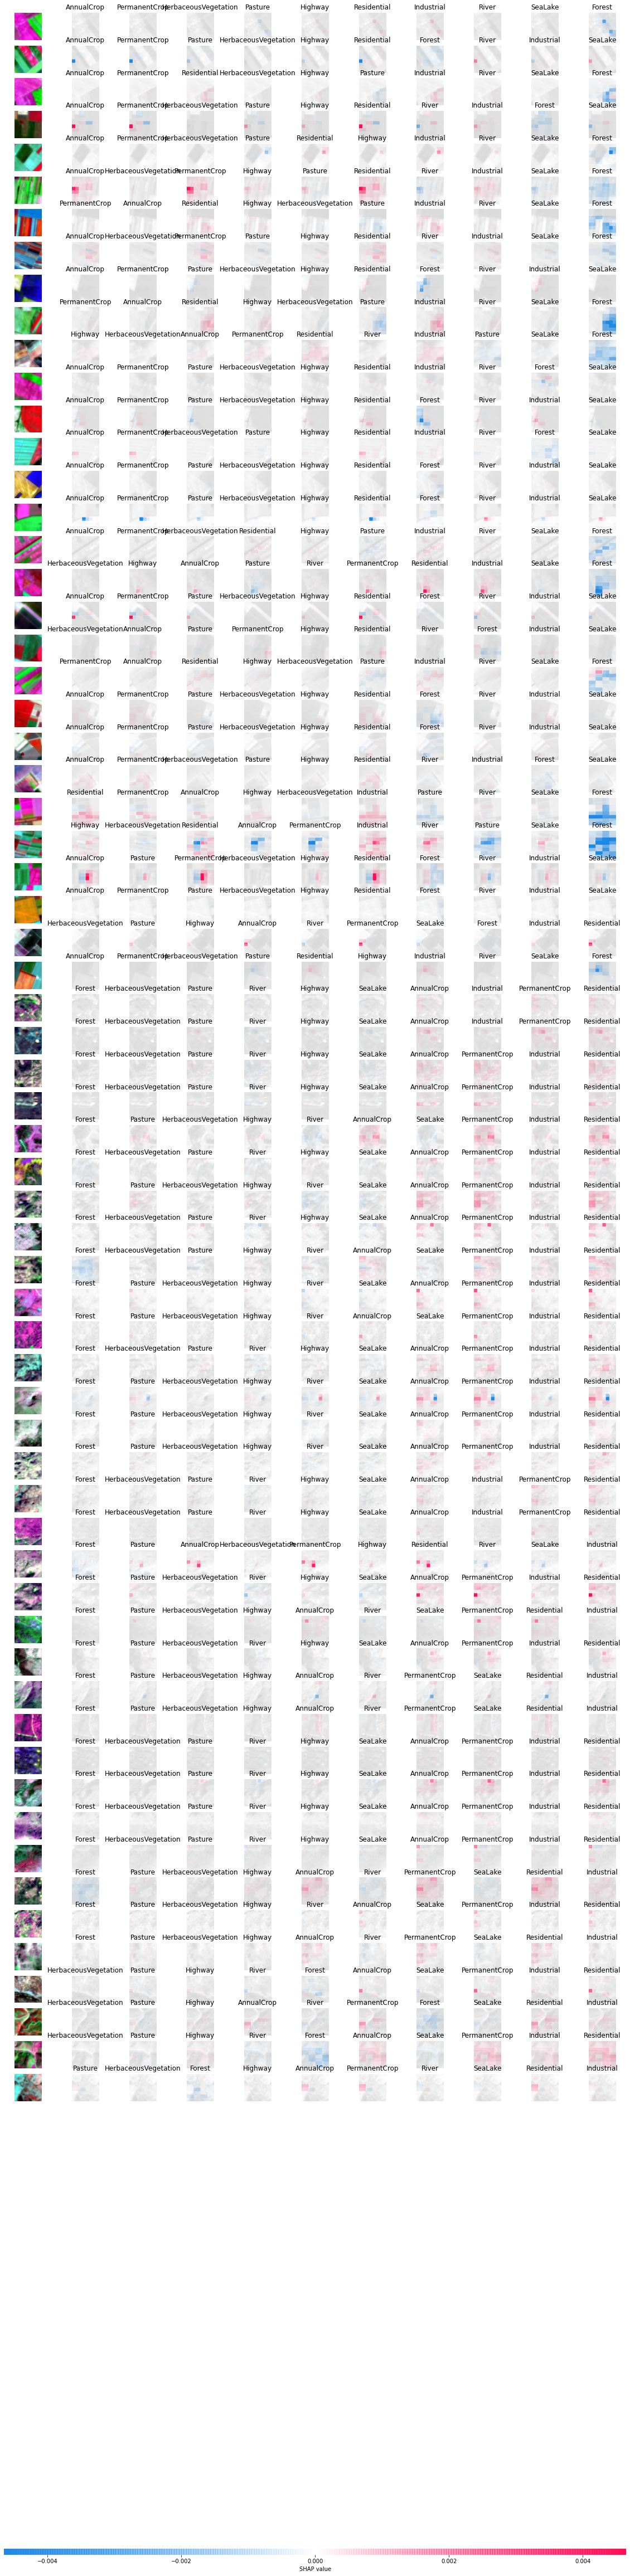

In [62]:
# Plot PartitionSHap result
shap.image_plot(shap_values)

# Q: What does the plot of the image itself mean? A 13-band raster as RGB image?
# [from shap/plots/_image.py]:
#   " for non-RGB multi-channel data we show an RGB image where 
#     each of the three channels is a scaled k-mean center
#   "

# Q: If Shap values are for a (y = model(x)) instance, how can it have Shap values for all other classes?
# [from original SHAP paper]: showing images for MNIST 8 and 3 for input 8,
#   " we masked 20% of the pixels chosen to switch the predicted class from 8 to 3 
#     according to the feature attribution given by each method
#   "